In [101]:
import pandas as pd

df = pd.read_csv("data/OGNT_processed.csv")
df.sample(8)

,Unnamed: 0,book,chapter,verse,word,lemma,trans,author
34718,34718,lk,6,49,εκεινης,ἐκεῖνος,that,luke
40135,40135,lk,12,30,κοσμου,κόσμος,world,luke
41611,41611,lk,14,18,ο,ὁ,the/this/who,luke
45565,45565,lk,20,30,και,καί,and,luke
63224,63224,j,19,23,δι,διά,through/because of,john
38003,38003,lk,10,9,βασιλεια,βασιλεία,kingdom,luke
17206,17206,mt,27,14,προς,πρός,to/with,matthew
101810,101810,gal,1,12,γαρ,γάρ,for,paul


In [102]:
import numpy as np

print(f"Words total: {len(df["word"])}")
print(f"Unique words: {len(np.unique(df["word"]))}")
print(f"Unique lemmas: {len(np.unique(df["lemma"]))}")

Words total: 138013
Unique words: 18310
Unique lemmas: 5395


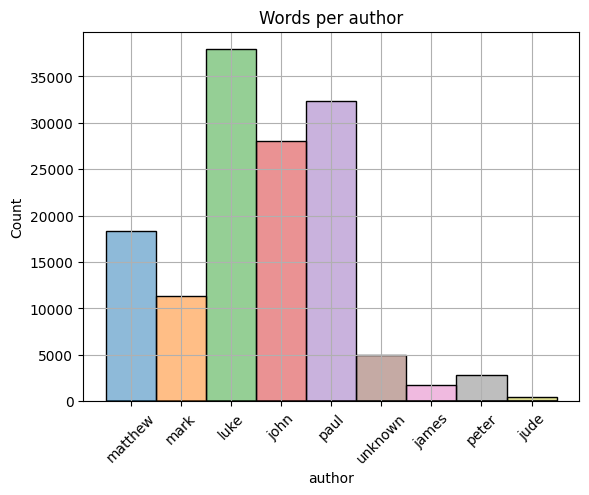

In [103]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(df, x="author", hue="author", legend=False)
plt.grid()
plt.title("Words per author")
plt.xticks(rotation=45)
plt.show()

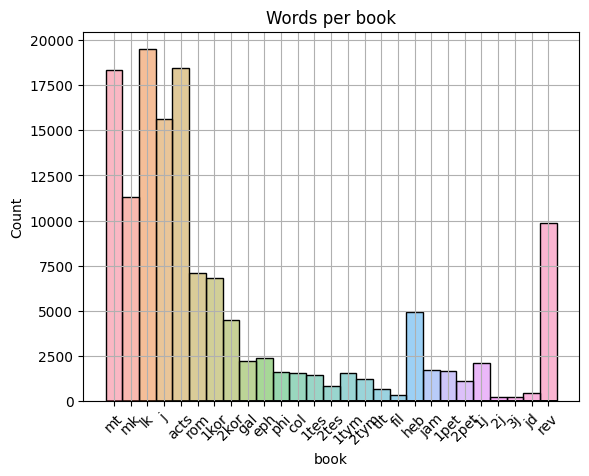

In [104]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(df, x="book", hue="book", legend=False)
plt.grid()
plt.title("Words per book")
plt.xticks(rotation=45)
plt.show()

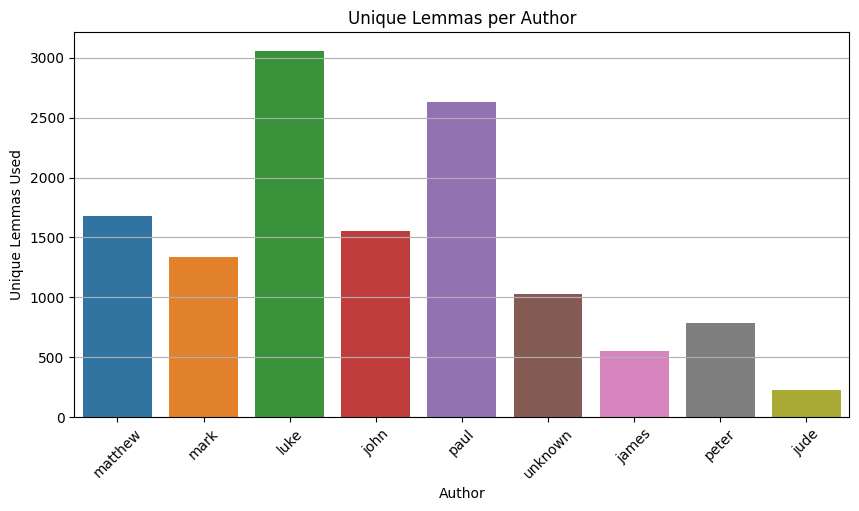

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique lemmas per author
author_lemmas = df.groupby("author", sort=False)["lemma"].nunique().reset_index()

# Plot histogram
plt.figure(figsize=(10, 5))
plt.grid()
sns.barplot(x="author", y="lemma", hue="author", data=author_lemmas)

plt.xlabel("Author")
plt.ylabel("Unique Lemmas Used")
plt.title("Unique Lemmas per Author")
plt.xticks(rotation=45)

plt.show()


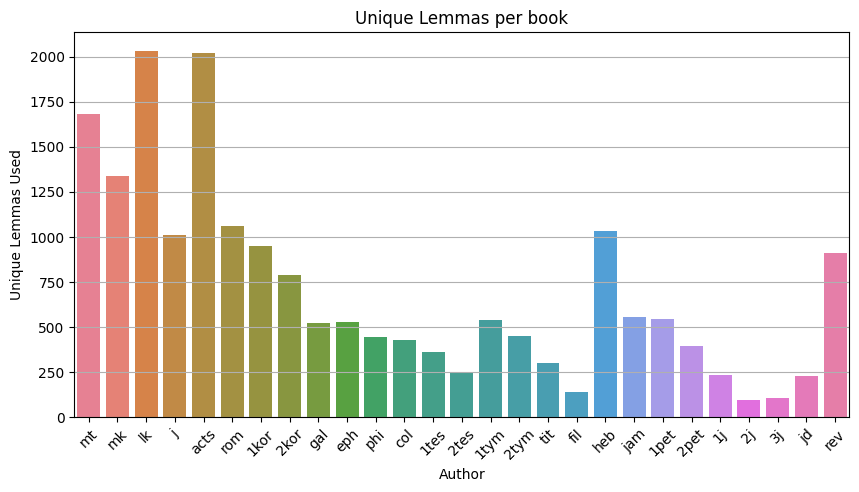

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique lemmas per book
author_lemmas = df.groupby("book", sort=False)["lemma"].nunique().reset_index()

# Plot histogram
plt.figure(figsize=(10, 5))
plt.grid()
sns.barplot(x="book", y="lemma", hue="book", data=author_lemmas)

plt.xlabel("Author")
plt.ylabel("Unique Lemmas Used")
plt.title("Unique Lemmas per book")
plt.xticks(rotation=45)

plt.show()

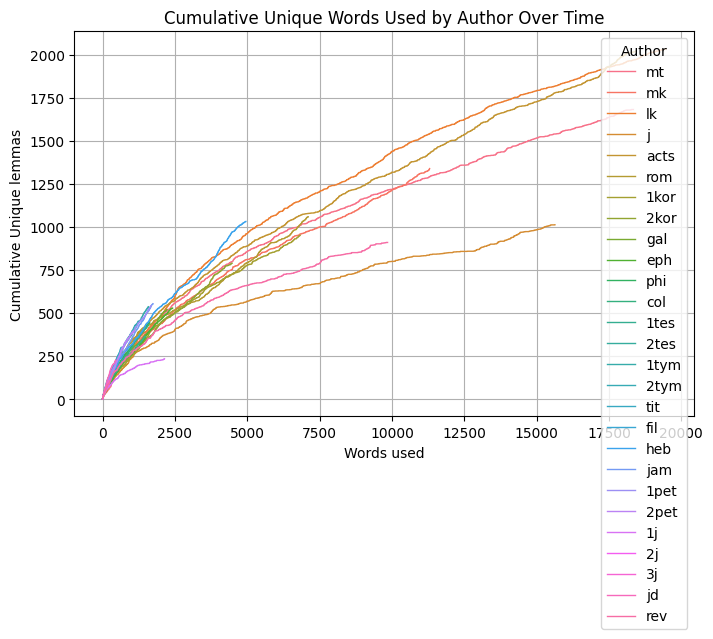

In [107]:
df["b_pos"] = df.groupby("book", sort=False).cumcount() + 1


df["b_unq"] = ~df.duplicated(subset = ["book", "lemma"])
df["b_unq"] = df.groupby("book", sort=False)["b_unq"].cumsum()

# Plot the progression
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="b_pos", y="b_unq", hue="book", lw=1)

plt.xlabel("Words used")
plt.ylabel("Cumulative Unique lemmas")
plt.title("Cumulative Unique Words Used by Author Over Time")
plt.legend(title="Author")
plt.grid()
plt.show()


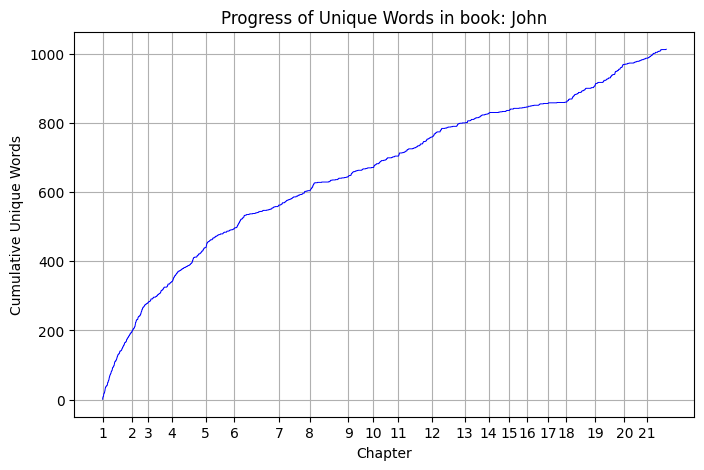

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

book = "j"

book_df = df[df["book"] == book].copy()

book_df["b_pos"] = range(1, len(book_df) + 1)

book_df["b_unq"] = ~book_df.duplicated(subset=["lemma"])
book_df["b_unq"] = book_df["b_unq"].cumsum()

chapter_positions = book_df.groupby("chapter")["b_pos"].first()

plt.figure(figsize=(8, 5))
sns.lineplot(data=book_df, x="b_pos", y="b_unq", color="b", linewidth=0.7)

plt.xticks(ticks=chapter_positions, labels=chapter_positions.index)

plt.xlabel("Chapter")
plt.ylabel("Cumulative Unique Words")
plt.title(f"Progress of Unique Words in book: John")
plt.grid()
plt.show()


In [109]:
import pandas as pd
from collections import Counter

In [110]:
def compute_author_ngram_frequencies(df: pd.DataFrame, n: int = 2) -> dict:
   
    freqs = {}  # dane dla każdego autora

    for author, group in df.groupby("author", sort=False):
        words = group["lemma"].tolist()
        ngrams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
        author_ngram_counts = Counter(ngrams)
        total_ngrams_author = sum(author_ngram_counts.values())
        freqs[author] = {}
        for ngram, count in author_ngram_counts.items():
            freqs[author][ngram] = count / total_ngrams_author

    return freqs

In [111]:
def cng_distance(freq_x: dict, freq_y: dict, L: int = 1000) -> float:
    
    # Sortujemy n-gramy w freq_x i freq_y malejąco wg częstości
    top_x = sorted(freq_x.items(), key=lambda x: x[1], reverse=True)[:L]
    top_y = sorted(freq_y.items(), key=lambda x: x[1], reverse=True)[:L]
    # Wyciągamy same n-gramy (bez częstości) i robimy z nich set
    top_x_ngrams = set([ng[0] for ng in top_x])
    top_y_ngrams = set([ng[0] for ng in top_y])
    
    # Unia najczęstszych n-gramów
    union_ngrams = top_x_ngrams.union(top_y_ngrams)
    
    distance = 0.0
    for g in union_ngrams:
        fxg = freq_x.get(g, 0.0)
        fyg = freq_y.get(g, 0.0)
        denominator = fxg + fyg
        if denominator != 0:
            numerator = 2.0 * (fxg - fyg)
            distance += (numerator / denominator) ** 2
    
    return distance


In [112]:
freqs = compute_author_ngram_frequencies(df, n=2)

In [ ]:
authors = list(freqs.keys())
distances = {}
L_chosen = 7

for i in range(len(authors)):
    for j in range(i+1, len(authors)):
        a1 = authors[i]
        a2 = authors[j]
        dist = cng_distance(freqs[a1], freqs[a2], L=L_chosen)
        distances[(a1, a2)] = dist

print(distances)
unknow_author = {k: v for k, v in distances.items() if "unknown" in k}
print(unknow_author)
unknown_value = min(unknow_author.values())
unknown_value_author = {k: v for k, v in unknow_author.items() if v == unknown_value}
print(F"Unkown autor with min distance: {unknown_value} is {unknown_value_author}")


{('matthew', 'mark'): 1.1679545751486866, ('matthew', 'luke'): 2.2819419042330447, ('matthew', 'john'): 5.474661702358841, ('matthew', 'paul'): 11.225856159220747, ('matthew', 'unknown'): 13.532625177938943, ('matthew', 'james'): 18.700663507467233, ('matthew', 'peter'): 20.463749377893098, ('matthew', 'jude'): 36.84332400804838, ('mark', 'luke'): 3.964146050697663, ('mark', 'john'): 4.882998165657311, ('mark', 'paul'): 12.92978574932767, ('mark', 'unknown'): 15.206759811364385, ('mark', 'james'): 20.064535629942604, ('mark', 'peter'): 23.174867011768697, ('mark', 'jude'): 37.32110317630926, ('luke', 'john'): 3.64649980641304, ('luke', 'paul'): 4.445629001564103, ('luke', 'unknown'): 6.956215347157153, ('luke', 'james'): 12.40704328296829, ('luke', 'peter'): 13.900715470990063, ('luke', 'jude'): 31.9912615546598, ('john', 'paul'): 9.34312336518216, ('john', 'unknown'): 12.249016653231017, ('john', 'james'): 15.714202391235645, ('john', 'peter'): 17.543021856895315, ('john', 'jude'): 36